## Intro to TectModel

In [1]:
#load in parent stuff

import nb_load_stuff
from tectModelClass import *

importing Jupyter notebook from tectModelClass.ipynb


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [3]:
from unsupported_dan.utilities import *
from unsupported_dan.utilities import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection


../unsupported/unsupported_dan/utilities/__init__.py:9: UserWarning: 

The utilities module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """
../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [4]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Toy model

In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
coordinate = fn.input()


In [6]:
#toy model, 3 plates
############################
#-1        0.0  0.5    1.0
######1##### ###2###  ##3##
            #
             #
###########################

tg = TectModel(mesh, 0, 20, 1)

tg.add_plate(1, velocities = 1)
tg.add_plate(2,velocities = -1)
tg.add_plate(3, velocities = 0)
        
tg.add_left_boundary(1)
tg.add_subzone(1, 2, 0.25, subInitAge=50.0, upperInitAge=10.0)
tg.add_ridge(2, 3, 0.5)
tg.add_right_boundary(3, 30.)

In [7]:

tg.is_subduction_boundary((1,2))

True

In [8]:
#tg.is_subduction_boundary(2,1), tg.is_subduction_boundary(3,2)

#tg.subduction_boundary_from_plate(3)
#tg.is_subducting_plate(1)
#
#np.sort(tg.get_boundaries(1)).mean(),  np.sort(tg.get_boundaries(2)).mean()
#tg.subduction_direction(1,2)

#tg.subduction_boundary_from_plate(tg.subduction_direction(2,1))
#tg.subduction_boundary_from_plate(tg.subduction_edge_order(2,1)[0])

In [9]:
plateId =1
len(tg[plateId].keys()) == 1 and len(tg.undirected[plateId].keys()) ==2

False

In [10]:
plateId = 3
for b in tg.connected_plates(plateId ):
    print(b)
    if tg.has_edge(plateId, b) and tg.has_edge(b, plateId):
        pass
    else:
        print(tg.subduction_direction(plateId, b))
        break

2
3


In [11]:
plateId = 2
[i for i in tg.out_edges(plateId)]
#[i for i in tg.in_edges(plateId)]


[(2, 3)]

In [12]:
tg.in_edges(plateId)[0], tg.out_edges(plateId)[0]

((1, 2), (2, 3))

In [13]:
#pAgeDict


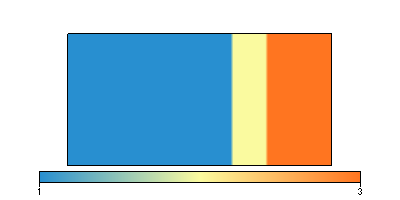

In [14]:
#for n in tg.nodes():
#    print(n)
#    bounds  = np.sort(tg.get_boundaries(n))
#    print('plate {}'.format(n), bounds)
    
    
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, pIdFn ))
fig.show()

In [15]:
#combMaskFn = operator.or_(RboundMaskFn, SboundMaskFn )


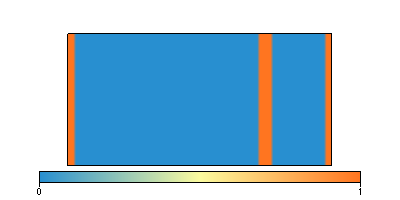

In [16]:
boundMaskFn = tg.plate_boundary_mask_fn(0.1)
RboundMaskFn = tg.ridge_mask_fn(0.05)
SboundMaskFn = tg.subduction_mask_fn(0.1)

#We can 'add' these mask functions like so
boundMaskFn = tg.combine_mask_fn(RboundMaskFn, SboundMaskFn )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, RboundMaskFn ))
fig.show()

In [17]:
#boundMaskFn.evaluate(mesh)


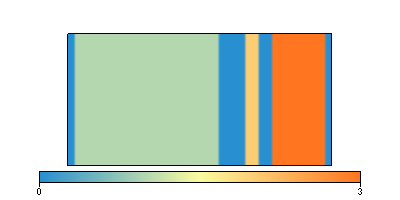

In [18]:
#We can also have  masked Plate Function 

maskedPlateIdFn = tg.plate_id_fn(maskFn=boundMaskFn)
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, maskedPlateIdFn , valueRange = [0, 3] ))
fig.show()

In [19]:
#loc = tg.get_edge_data( *tg.edges()[0])['loc']
#velocityField.evaluate_global((loc,1.0))

In [20]:
tg.nodes(), tg.edges()


([1, 2, 3], [(1, 1), (1, 2), (2, 3), (3, 2), (3, 3)])

In [21]:
#uw.systems.SwarmAdvector?

In [22]:

#We can traverse the undirect graph and use these functions to query the underlying directed data structue
for e in tg.undirected.edges():
    print(tg.is_ridge(e), tg.is_subduction_boundary(e))
    e = (e[1], e[0])
    print(tg.is_ridge(e), tg.is_subduction_boundary(e))

(True, False)
(True, False)
(False, True)
(False, True)
(True, False)
(True, False)
(True, False)
(True, False)



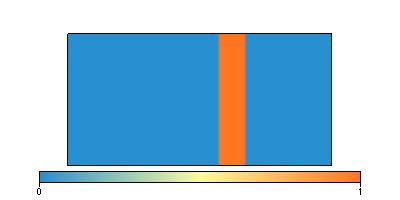

In [23]:
#Can also specify a single plate boundary

boundMaskFn2 = tg.plate_boundary_mask_fn(0.1, bound=(1,2))


fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, boundMaskFn2 ))
fig.show()

## Integration test

In [24]:
velocityField.data[:,0] =   tg.xFn.evaluate(mesh)[:,0] - tg.minX

In [25]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, fn2 ))
fig.show()

NameError: name 'fn2' is not defined

In [ ]:
#_surfLength  = uw.utils.Integral( boundMaskFn2, mesh=mesh, integrationType='Surface', surfaceIndexSet=tWalls)
#surfLength = _surfLength.evaluate()

In [ ]:
#Setup some mask Fns

conds1 = [ (         tg.xFn > 0.5,  1.),
                   (                                                   True , 0.) ]


conds2 = [ (         tg.xFn <= 0,  1.),
                   (       True , 0.) ]

fn1 = fn.branching.conditional(conds1 )
fn2 = fn.branching.conditional(conds2)


fnvector = [fn1, fn2]

In [ ]:
tWalls=mesh.specialSets["MaxJ_VertexSet"]
_surfLength  = uw.utils.Integral( fnvector, mesh=mesh, integrationType='Surface', surfaceIndexSet=tWalls)
surfLength = _surfLength.evaluate()

In [ ]:
surfLength

In [ ]:
#_mmVxSurf = fn.view.min_max(fn1, fn_auxiliary=tg.xFn )
#dummyFn = _mmVxSurf.evaluate(tWalls)

In [ ]:
#_mmVxSurf.max_global(), _mmVxSurf.max_global_auxiliary()

In [ ]:
testFn = tg.xFn <= 0

In [ ]:
test2 = operator.and_(testFn, testFn )

In [ ]:
operator.

## Scratch

In [17]:
tg.get_bound_loc((1,1)), tg.is_ridge((1,
                                      1))

(-1.0, True)

In [18]:
# initialise a swarm
swarmCustom = uw.swarm.Swarm( mesh=mesh )

swarmYs = np.linspace(0, 1, 50) 
swarmXs = np.ones(50)*0.25
swarmCoords = np.column_stack((swarmXs, swarmYs))
swarmCustom.add_particles_with_coordinates(swarmCoords)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int32)

In [19]:
tg.get_boundaries(2)

[0.25, 0.5]

In [22]:
testFn = tg.variable_boundary_mask_fn(distMax=0.3, distMin=0.05, boundaryFactor = 0.1, 
                                  minPlateLength = 0.2,  out = 'bool', boundtypes='ridge')

(0.125, 0.125)
(0.05, 0.05)
(0.05, 0.05)



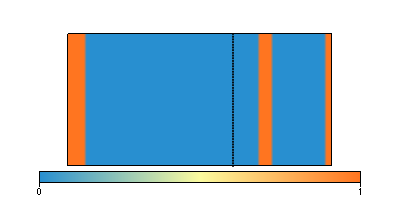

In [23]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, testFn ))
fig.append( glucifer.objects.Points(swarmCustom, pointSize = 3 ))

fig.show()

In [24]:
testFn2 = tg.plate_interior_mask_fn(boundaryFactor=0.8, minPlateLength=0.01)


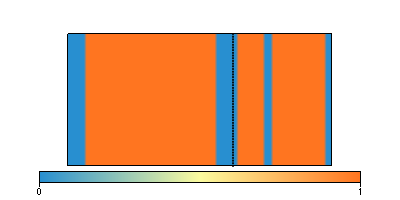

In [25]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, testFn2 ))
fig.append( glucifer.objects.Points(swarmCustom, pointSize = 3 ))

fig.show()